# Generate Dataset for Interactive Testing of Lumen and Joule

In [12]:
# run this cell first to import the packages
import joule
# convenience imports to make code more compact
from joule.api import EventStream, Event, DataStream, Element, Annotation
from joule.errors import EmptyPipeError
from random import randint
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# get_node() returns the default node, add a name parameter to request a specific one
node = joule.api.get_node()

# all node methods are async so you must use the await keyword
info = await node.info()

print("Node [%s] running joule %s" % (info.name, info.version))

Node [joule] running joule 0.9.53.dev1+g8426eec.d20240228


### Create data streams and write data

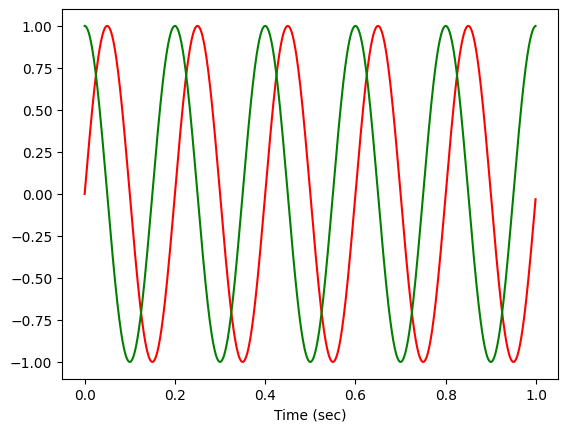

In [3]:
# create a two element stream of 5Hz sine, cosine waveforms
freq = 5.0
t = np.arange(0,1,0.001) # 1ms sample rate
sine = np.sin(freq*2*np.pi*t)
cosine = np.cos(freq*2*np.pi*t)
tangent = np.tan(freq*2*np.pi*t)
plt.plot(t, sine, 'r', t, cosine, 'g')
plt.xlabel('Time (sec)')
plt.show()


In [4]:
# create a stream on the Joule Node that can store this data
stream = DataStream(name="waves", elements=[Element(name="sine"), Element(name="cosine")])
stream = await node.data_stream_create(stream,"/api_demo") # now stream is a registered model and can be used with API calls

data = np.vstack((t*1e6, sine, cosine)).T
pipe = await node.data_write(stream)
await pipe.write(data) # timestamps should be in us
await pipe.close() # make sure to close the pipe after writing


## Event Streams

Add two events to a stream to test boundary conditions

In [6]:
# create a stream on the Joule Node that can store this data
stream = await node.event_stream_get("/events/small_events", create=True)
event1 = Event(start_time=0, end_time=0.1e6, 
               content={'height':1,'color':'red','description':'first one'})
event2 = Event(start_time=.3e6, end_time=0.5e6, 
               content={'height':2,'color':'blue','description':'second one'})

await node.event_stream_write(stream, [event1, event2])

Add 500 events to a stream to test decimation visualization

In [15]:
stream = await node.event_stream_get("/events/many_events", create=True)
events = []
for i in range(1000):
    ts = randint(0,1e6)
    duration = 1e2
    event = Event(start_time=ts, end_time=ts+duration, 
               content={'height':1,'color':'red','description':'first one'})
    events.append(event)
x = await node.event_stream_write(stream, events)

### Reset the Node to original state
**Run this cell to undo all changes created by this notebook**

In [ ]:
await node.folder_delete("/api_demo")